In [ ]:
# try:
#     import kaggle
# except ImportError:
#     import sys
#     import subprocess
#     subprocess.check_call([sys.executable, "-m", "pip", "install", "kaggle"])
#     import kaggle

# !kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

In [1]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 99% 147M/149M [00:09<00:00, 21.0MB/s]
100% 149M/149M [00:09<00:00, 15.8MB/s]


In [2]:
!unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

## Before you proceed:
- Unzip the downloaded dataset
- Move the directories (Training and Testing) to the same directory of the current file.

In [3]:
import torch  # PyTorch library
import torchvision.transforms as transforms  # transforms from torchvision for data preprocessing
import torchvision.datasets as datasets  # datasets from torchvision for loading data
from torch.utils.data import DataLoader  # DataLoader from PyTorch for batching and shuffling data
import matplotlib.pyplot as plt  # matplotlib for data visualization
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import os
import json

In [4]:
train_dir = "Training"  # Directory path for training data
test_dir = "Testing"  # Directory path for testing data
FINAL_IMAGE_SIZE = 128

basic_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize([FINAL_IMAGE_SIZE, FINAL_IMAGE_SIZE]),
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

In [5]:
# Load datasets with basic transformations
train_dataset = datasets.ImageFolder(root=train_dir, transform=basic_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=basic_transform)

torch.Size([1, 128, 128])


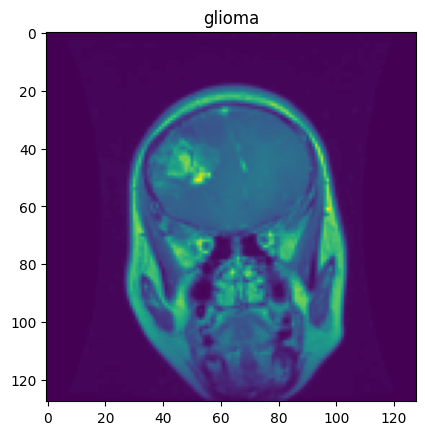

In [6]:
# Plot the first image as a sample
sample_img, sample_cls = train_dataset[0]
plt.imshow(sample_img.numpy().transpose(1, 2, 0))
# Add the title to indicate the class
plt.title(train_dataset.classes[sample_cls])
print(sample_img.shape)

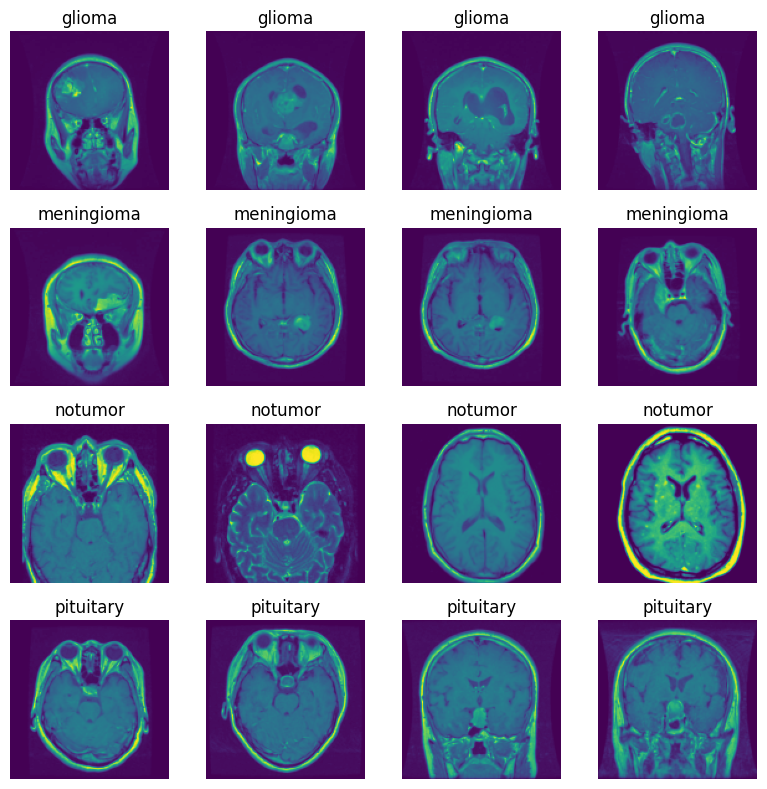

In [7]:
iterable_dataset = iter(train_dataset)
i = 0
sample_dict = {}
count_dict = {}
plt.figure(figsize=(8, 8))

# Iterate through the dataset, count samples for each class,
# and display up to 4 images per class
while True:
    try:
        im, cls = next(iterable_dataset)
        count_dict.setdefault(cls, 0)
        count_dict[cls] += 1
    except StopIteration:
        break

    sample_dict.setdefault(cls, 0)
    if sample_dict[cls] >= 4:
        continue

    sample_dict[cls] += 1
    i += 1
    plt.subplot(4, 4, i)
    plt.imshow(im.numpy().transpose(1, 2, 0))
    plt.title(train_dataset.classes[cls])
    plt.axis("off")

plt.tight_layout()

Text(0.5, 1.0, 'Frequency Distribution of classes')

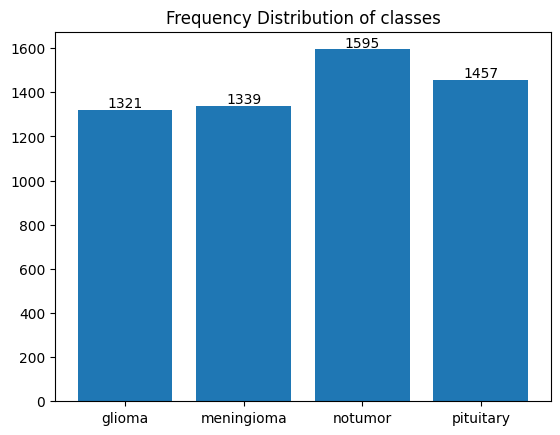

In [8]:
# Make a bar plot to indicate the frequency distribution
plt.bar(train_dataset.classes, count_dict.values())
for i, val in count_dict.items():
    plt.text(i, val + 10, val, ha="center")

plt.title("Frequency Distribution of classes")

In [9]:
BATCH_SIZE = 4

In [10]:
# Create dataloaders with a batch size of 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
print(f"Training samples: {len(train_dataset)}, Training batches: {len(train_loader)}")
print(f"Testing samples: {len(test_dataset)}, Testing batches: {len(test_loader)}")

Training samples: 5712, Training batches: 1428
Testing samples: 1311, Testing batches: 328


In [12]:
train_dataset[0][0].size()

torch.Size([1, 128, 128])

### Augmentation

In [15]:
general_transforms = {
    'train': transforms.Compose([
        # Data augmentation and transformation for training set
        transforms.Grayscale(),
        transforms.Resize((512, 512)),  # Resize images to 512x512
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomRotation(10),  # Randomly rotate images
        transforms.RandomResizedCrop(256, scale=(0.8, 1)),  # Randomly crop and resize images
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        # Transformation for testing set
        transforms.Resize((512, 512)),  # Resize images to 512x512
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets with the defined transformations
train_dataset_aug = datasets.ImageFolder(root=train_dir, transform=general_transforms['train'])
test_dataset_aug = datasets.ImageFolder(root=test_dir, transform=general_transforms['test'])

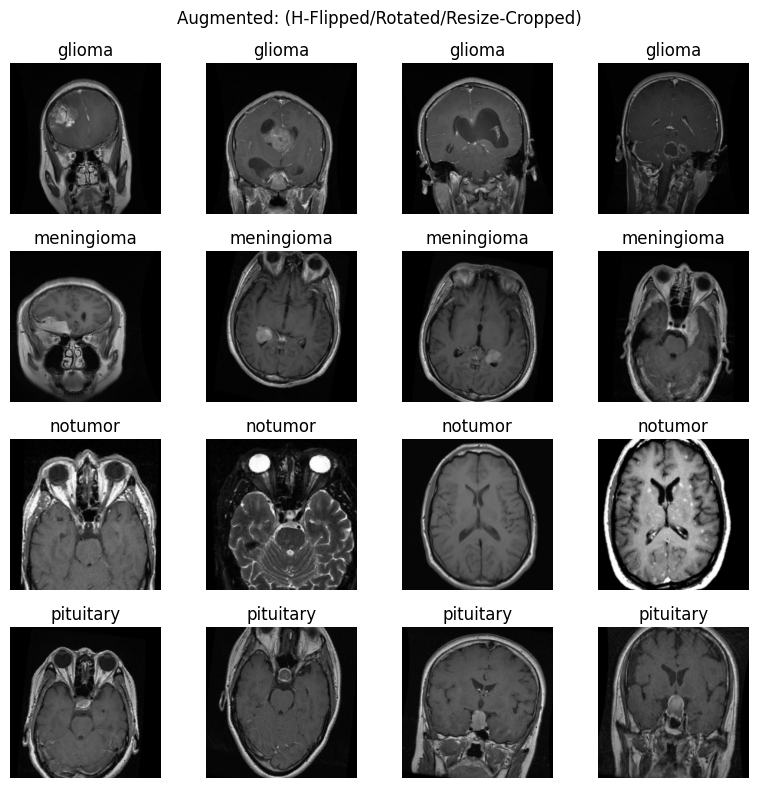

In [14]:
iterable_dataset = iter(train_dataset_aug)
i = 0
sample_dict = {}
count_dict = {}
plt.figure(figsize=(8, 8))
while True:
    try:
        im, cls = next(iterable_dataset)
        count_dict.setdefault(cls, 0)
        count_dict[cls] += 1
    except StopIteration:
        break

    sample_dict.setdefault(cls, 0)
    if sample_dict[cls] >= 4:
        continue

    sample_dict[cls] += 1
    i += 1
    plt.subplot(4, 4, i)
    plt.imshow(im.numpy().transpose(1, 2, 0))
    plt.title(train_dataset_aug.classes[cls])
    plt.axis("off")

plt.suptitle("Augmented: (H-Flipped/Rotated/Resize-Cropped)")
plt.tight_layout()

In [16]:
# Create dataloaders with a batch size of 32
train_loader_aug = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE, shuffle=True)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
print(f"[AUG] Training samples: {len(train_dataset)}, Training batches: {len(train_loader)}")
print(f"[AUG] Testing samples: {len(test_dataset)}, Testing batches: {len(test_loader)}")

[AUG] Training samples: 5712, Training batches: 1428
[AUG] Testing samples: 1311, Testing batches: 328


In [18]:
from torch.utils.data import ConcatDataset

# Concatenate regualr dataset and augmented dataset into a single dataset
train_dataset_reg_aug = ConcatDataset([train_dataset, train_dataset_aug])
test_dataset_reg_aug = ConcatDataset([test_dataset, test_dataset_aug])

# Create dataloaders with a batch size of 32
train_loader_reg_aug = DataLoader(train_dataset_reg_aug, batch_size=BATCH_SIZE, shuffle=True)
test_loader_reg_aug = DataLoader(test_dataset_reg_aug, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
print(f"[REG+AUG] Training samples: {len(train_dataset_reg_aug)}, Training batches: {len(train_loader_reg_aug)}")
print(f"[REG+AUG] Testing samples: {len(test_dataset_reg_aug)}, Testing batches: {len(test_loader_reg_aug)}")

[REG+AUG] Training samples: 11424, Training batches: 2856
[REG+AUG] Testing samples: 2622, Testing batches: 656


### GAN

![image.png](attachment:image.png)

([Credits](https://www.researchgate.net/publication/338050169/figure/fig5/AS:849390331777024@1579521844061/The-general-architecture-of-GAN.ppm))

In [20]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512 * 8, 4, 1, 0, bias=False),  # 4x4
            nn.BatchNorm2d(512 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(512 * 8, 512 * 4, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(512 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(512 * 4, 512 * 2, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(512 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(512 * 2, 512, 4, 2, 1, bias=False),  # 32x32
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # 64x64
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 128x128
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # 256x256
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),  # 512x512
            nn.Tanh()  # Output in the range [-1, 1]
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),  # 256x256
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),  # 128x128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),  # 64x64
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),  # 32x32
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512 * 2, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(512 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512 * 2, 512 * 4, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(512 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512 * 4, 512 * 8, 4, 2, 1, bias=False),  # 4x4
            nn.BatchNorm2d(512 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512 * 8, 1, 4, 1, 0, bias=False),  # 1x1
            nn.Sigmoid()  # Output in the range [0, 1]
        )

    def forward(self, input):
        return self.main(input).view(-1)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to GPU if available, otherwise use CPU
netG = Generator().to(device)  # Move the Generator model to the selected device
netD = Discriminator().to(device)  # Move the Discriminator model to the selected device

print(f"Using device: {device}")  # Print the device being used

Using device: cuda


In [22]:
from torch import optim

criterion = nn.BCELoss()  # Binary Cross-Entropy loss function
lr = 0.0001  # Learning rate for the optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr)  # Adam optimizer for the Discriminator
optimizerG = optim.Adam(netG.parameters(), lr=lr)  # Adam optimizer for the Generator

In [23]:
import torchvision.utils as vutils

num_epochs = 10
nz = 100
USE_GAN = False

if USE_GAN:
    # Training loop
    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(train_loader):
            # Step 1: Update D network

            ## Train with real images
            netD.zero_grad()
            real_images = real_images.to(device)
            b_size = real_images.size(0)
            label = torch.full((b_size,), 1, dtype=torch.float, device=device)
            output = netD(real_images)
            errD_real = criterion(output, label)
            errD_real.backward()

            ## Train with fake images
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_images = netG(noise)
            label.fill_(0)
            output = netD(fake_images.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()
            optimizerD.step()
            errD = errD_real + errD_fake

            # Step 2: Update G network
            netG.zero_grad()
            label.fill_(1)
            output = netD(fake_images)
            errG = criterion(output, label)
            errG.backward()
            optimizerG.step()

            # Print training stats
            if i % 100 == 0:
                print(f'Epoch [{epoch}/{num_epochs}] Batch {i}/{len(train_loader)} \
                    Loss D: {errD.item():.4f}, Loss G: {errG.item():.4f}')

        # Save images every 10 epochs
        # if epoch % 10 == 0:
        #     with torch.no_grad():
        #         fake = netG(noise).detach().cpu()
        #     vutils.save_image(fake, f'output/fake_images_epoch_{epoch}.png', normalize=True)

    # # Save the trained models
    # torch.save(netG.state_dict(), 'generator.pth')
    # torch.save(netD.state_dict(), 'discriminator.pth')

### VGG-16

![image.png](attachment:image.png)

([Credits](https://www.google.com/url?sa=i&url=https%3A%2F%2Flekhuyen.medium.com%2Fan-overview-of-vgg16-and-nin-models-96e4bf398484&psig=AOvVaw03WeTMJ-5pIsqZClDBsrAp&ust=1720557631285000&source=images&cd=vfe&opi=89978449&ved=0CBEQjRxqFwoTCMjNqeammIcDFQAAAAAdAAAAABAE))

In [24]:
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # Convolutional Block 1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output shape: 64 x 64

            # Convolutional Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output shape: 32 x 32

            # Convolutional Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output shape: 16 x 16

            # Convolutional Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output shape: 8 x 8

            # Convolutional Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output shape: 4 x 4
        )

        self.classifier = nn.Sequential(
            # 512 -> Conv Block 1: 256 -> Conv Block 2: 128 -> Conv Block 3: 64
            # -> Conv Block 4: 32 -> Conv Block 5: 16
            # we end up with 16x16 images after conv block 5.
            nn.Linear(512 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Instantiate the model
num_classes = 4  # 4 different types of tumors
vgg_model = VGG16(num_classes)
# print(vgg_model)

In [25]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)

Using Device: cuda


In [30]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=learning_rate)

_ = vgg_model.to(device)

In [31]:
# Set up TensorBoard writer
log_dir = "runs/VGG16"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

writer = SummaryWriter(log_dir)

tensorboard_log = False

In [34]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    #Set the model to training mode
    vgg_model.train()
    # Initialize metrics to 0
    running_loss = 0.0
    correct = 0
    total = 0

    # for batch wise metrics
    batch_train_losses = []
    batch_train_accuracies = []

    for batch, (images, labels) in enumerate(train_loader):
        # Transfer the data on to current device

        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = vgg_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Calculate running loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(axis=1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Compute batch loss and accuracy
        batch_loss = loss.item()
        batch_accuracy = (predicted.eq(labels).sum().item() / labels.size(0)) * 100

        batch_train_losses.append(batch_loss)
        batch_train_accuracies.append(batch_accuracy)

        if tensorboard_log:
            # Log batch-wise metrics to TensorBoard
            writer.add_scalar(f"Batchwise Training Loss/Epoch {epoch+1}", batch_loss, batch)
            writer.add_scalar(f"Batchwise Training Accuracy/Epoch {epoch+1}", batch_accuracy, batch)

        # Print batch metrics every 50 batches
        # if (batch + 1) % 50 == 0:
            # print(f"Epoch [{epoch+1}/{num_epochs}] | [{batch+1}/{len(train_loader)}] | Batch Loss: {batch_loss:.4f} | Batch Accuracy: {batch_accuracy:.2f}%")


    # Compute epoch loss and accuracy
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = (correct / total) * 100

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    if tensorboard_log:
        writer.add_scalar("Training Loss", epoch_loss, epoch)
        writer.add_scalar("Training Accuracy", epoch_accuracy, epoch)

    # Validation
    # Set the model to validation mode
    vgg_model.eval()
    # Initialize metrics to 0
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            # Transfer the data on to current device
            images = images.to(device)
            labels = labels.to(device)

            outputs = vgg_model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(axis=1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / len(test_loader.dataset)
    val_accuracy = (correct / total) * 100

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    if tensorboard_log:
        writer.add_scalar("Validation Loss", val_loss, epoch)
        writer.add_scalar("Validation Accuracy", val_accuracy, epoch)

# Save the model checkpoint
torch.save(vgg_model.state_dict(), "vgg16.pth")

# Close the TensorBoard writer
writer.close()

# Save the metrics to a file
metrics = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies
}
with open('metrics.json', 'w') as f:
    json.dump(metrics, f)

Epoch [1/10], Loss: 0.3463, Accuracy: 27.66%
Validation Loss: 0.3460, Validation Accuracy: 30.89%
Epoch [2/10], Loss: 0.3463, Accuracy: 27.47%
Validation Loss: 0.3458, Validation Accuracy: 30.89%
Epoch [3/10], Loss: 0.3460, Accuracy: 28.26%
Validation Loss: 0.3455, Validation Accuracy: 30.89%
Epoch [4/10], Loss: 0.3460, Accuracy: 27.77%
Validation Loss: 0.3460, Validation Accuracy: 30.89%
Epoch [5/10], Loss: 0.3461, Accuracy: 27.29%
Validation Loss: 0.3451, Validation Accuracy: 30.89%
Epoch [6/10], Loss: 0.3461, Accuracy: 27.61%
Validation Loss: 0.3457, Validation Accuracy: 30.89%
Epoch [7/10], Loss: 0.3461, Accuracy: 27.56%
Validation Loss: 0.3455, Validation Accuracy: 30.89%
Epoch [8/10], Loss: 0.3461, Accuracy: 27.82%
Validation Loss: 0.3458, Validation Accuracy: 30.89%
Epoch [9/10], Loss: 0.3461, Accuracy: 27.52%
Validation Loss: 0.3452, Validation Accuracy: 30.89%
Epoch [10/10], Loss: 0.3460, Accuracy: 27.92%
Validation Loss: 0.3456, Validation Accuracy: 30.89%
